<a href="https://colab.research.google.com/github/RizwaZain/Data-Science-Analytics/blob/main/Classification_Model_Drug_Side_Effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [3]:
import nltk
from wordcloud import WordCloud, STOPWORDS
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import  WordNetLemmatizer
nltk.download('wordnet')
from textblob import TextBlob
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py

# 1 Data Exploration

**Loading the Dataset**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/drug_dataset.csv')


**Data Exploration**

In [7]:
data.head(15)

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1
5,55-64,Other,7/19/2008,warfarin (bulk) 100 % powder,144731,4,4,help heart condition operation well,4,Male,,0
6,25-34,Birth Control,6/15/2017,wymzya fe,163180,5,5,Haven't gotten pregnant so it does it's job. I...,2,Female,"Nausea , vomiting , headache , bloating , ...",0
7,45-54,Disease of Ovaries with Cysts,1/30/2017,wymzya fe,163180,5,5,I have take this for 5 years age 45-50 to prev...,5,Female,"Nausea , vomiting , headache , bloating , ...",0
8,25-34,Acne,4/27/2016,wymzya fe,163180,4,2,,2,Female,"Nausea , vomiting , headache , bloating , ...",1
9,55-64,Stuffy Nose,10/29/2012,"12 hour nasal relief spray, non-aerosol",9800,4,2,The 12 hour spray only works for me for 6 hours.,2,Male,"Temporary burning, stinging, dryness in the no...",0


In [8]:
data.tail()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
362801,55-64,Stop Smoking,11/14/2008,chantix,144470,5,5,I took the whole 12 weeks.I could have stopped...,5,Female,"Nausea , headache , vomiting , drowsiness, g...",2
362802,,Other,11/14/2008,chantix,144470,2,3,My dad strated taking Chantix about 1 month ag...,1,,"Nausea , headache , vomiting , drowsiness, g...",16
362803,25-34,Stop Smoking,11/13/2008,chantix,144470,2,4,"As long as I was on chantix, I didn't smoke. ...",2,Female,"Nausea , headache , vomiting , drowsiness, g...",3
362804,55-64,Stop Smoking,11/13/2008,chantix,144470,5,5,Started this medication Oct 5th 2008. Haven't ...,5,Male,"Nausea , headache , vomiting , drowsiness, g...",1
362805,45-54,Stop Smoking,11/12/2008,chantix,144470,4,5,"One year ago, I tried Chantix and had to stop ...",5,Female,"Nausea , headache , vomiting , drowsiness, g...",3


In [9]:
data.columns

Index(['Age', 'Condition', 'Date', 'Drug', 'DrugId', 'EaseofUse',
       'Effectiveness', 'Reviews', 'Satisfaction', 'Sex', 'Sides',
       'UsefulCount'],
      dtype='object')

In [10]:
data.shape

(362806, 12)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362806 entries, 0 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            362806 non-null  object
 1   Condition      362806 non-null  object
 2   Date           362806 non-null  object
 3   Drug           362806 non-null  object
 4   DrugId         362806 non-null  int64 
 5   EaseofUse      362806 non-null  int64 
 6   Effectiveness  362806 non-null  int64 
 7   Reviews        362769 non-null  object
 8   Satisfaction   362806 non-null  int64 
 9   Sex            362806 non-null  object
 10  Sides          362806 non-null  object
 11  UsefulCount    362806 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 33.2+ MB


**Selecting only relavant features**

the feature 'date' has no relavance since it  is not a time-series dataset. Also 'Sides' when analyzed is like each particular drug have the same symptoms in the 'Sides' column. UsefulCount is the measure of how useful the review was to others. So these columns are removed.

In [12]:
data=data.drop(['Date','Sides','UsefulCount'],axis=1)

In [13]:
for cols in data.columns:
    print(cols,':',data[cols].nunique(),'\n')

Age : 12 

Condition : 1806 

Drug : 7093 

DrugId : 6572 

EaseofUse : 7 

Effectiveness : 7 

Reviews : 250167 

Satisfaction : 7 

Sex : 3 



Observation: 
i. Drug is more in no. than DrugID 
ii. Sex has 3 values

In [14]:
for cols in data.columns:
  print("*****")
  print((data[cols].value_counts()).to_frame(),'\n')
 

*****
              Age
45-54       80043
55-64       75136
35-44       55011
25-34       49718
65-74       41216
19-24       24230
75 or over  15226
            12202
13-18        7045
7-12         1644
3-6           838
0-2           497 

*****
                                                    Condition
Other                                                   49765
Pain                                                    25232
High Blood Pressure                                     23275
Depression                                              14509
Birth Control                                           12253
...                                                       ...
Skin Disease with Hardened Patches of Skin                  1
Test Performed to Diagnose Growth Hormone Problems          1
Infected Conjunctiva by Chlamydia Trachomatis B...          1
Increased Uric Acid due to Cancer Chemotherapy              1
Intestinal Parasitic Infection                              1

[1806 r

Observation: Age, Reviews, Sex need to be cleaned

#2 Data Preprocessing

**2.1 Data Cleaning**

**A. Handling Missing values**

In [15]:
data.isna().sum()

Age               0
Condition         0
Drug              0
DrugId            0
EaseofUse         0
Effectiveness     0
Reviews          37
Satisfaction      0
Sex               0
dtype: int64

In [16]:
#removing rows with missing reviews
data=data.dropna(axis=0)

**B. Data Wrangling**

**white spaces**

I strip leading and trailing white spaces from string type data. These white spaces often conceal the fact that there is nothing useful in the data cell simply because white spaces are data as well.

In [17]:
for col in data.columns:
    if data[col].dtype.kind == "O":
        data[col] = data[col].str.strip()

Before I explore the individual columns, I would like to see how many missing values are in the dataset. Previously I already deleted the null value rows but I also deleted leading and trailing white space which may have created new empty cells

In [18]:
for i in data:
    data[i]=np.where(data[i]=="",np.NAN,data[i])

In [19]:
#handling new misssing values genereated
data.isna().sum()

Age              12199
Condition           43
Drug                 0
DrugId               0
EaseofUse            0
Effectiveness        0
Reviews          41846
Satisfaction         0
Sex              26533
dtype: int64

In [20]:
data=data.dropna(axis=0)

**Age**

Age column is object datatype, beacause it has values 75 or above, which should be removed, also then age is split to 2 columns, as in the dataset, it is an interval

In [21]:
def age_clean(age):
  dataframe=age.str.replace("or over", "")
  return dataframe

In [22]:
data['new_Age']=age_clean(data['Age'])

In [23]:
data['new_Age'].value_counts()

45-54    67415
55-64    61608
35-44    47142
25-34    44010
65-74    32440
19-24    21730
75       11447
13-18     6113
7-12      1404
3-6        687
0-2        425
Name: new_Age, dtype: int64

In [24]:
data=data.drop(['Age'],axis=1)

In [25]:
data.shape

(294421, 9)

**C. Text Processing**

**Reviews** 

The next step is to clean the column reviews. I have used stop words removal method, and visualizing reviews using wordcloud.

In [26]:
stops = set(stopwords.words('english'))

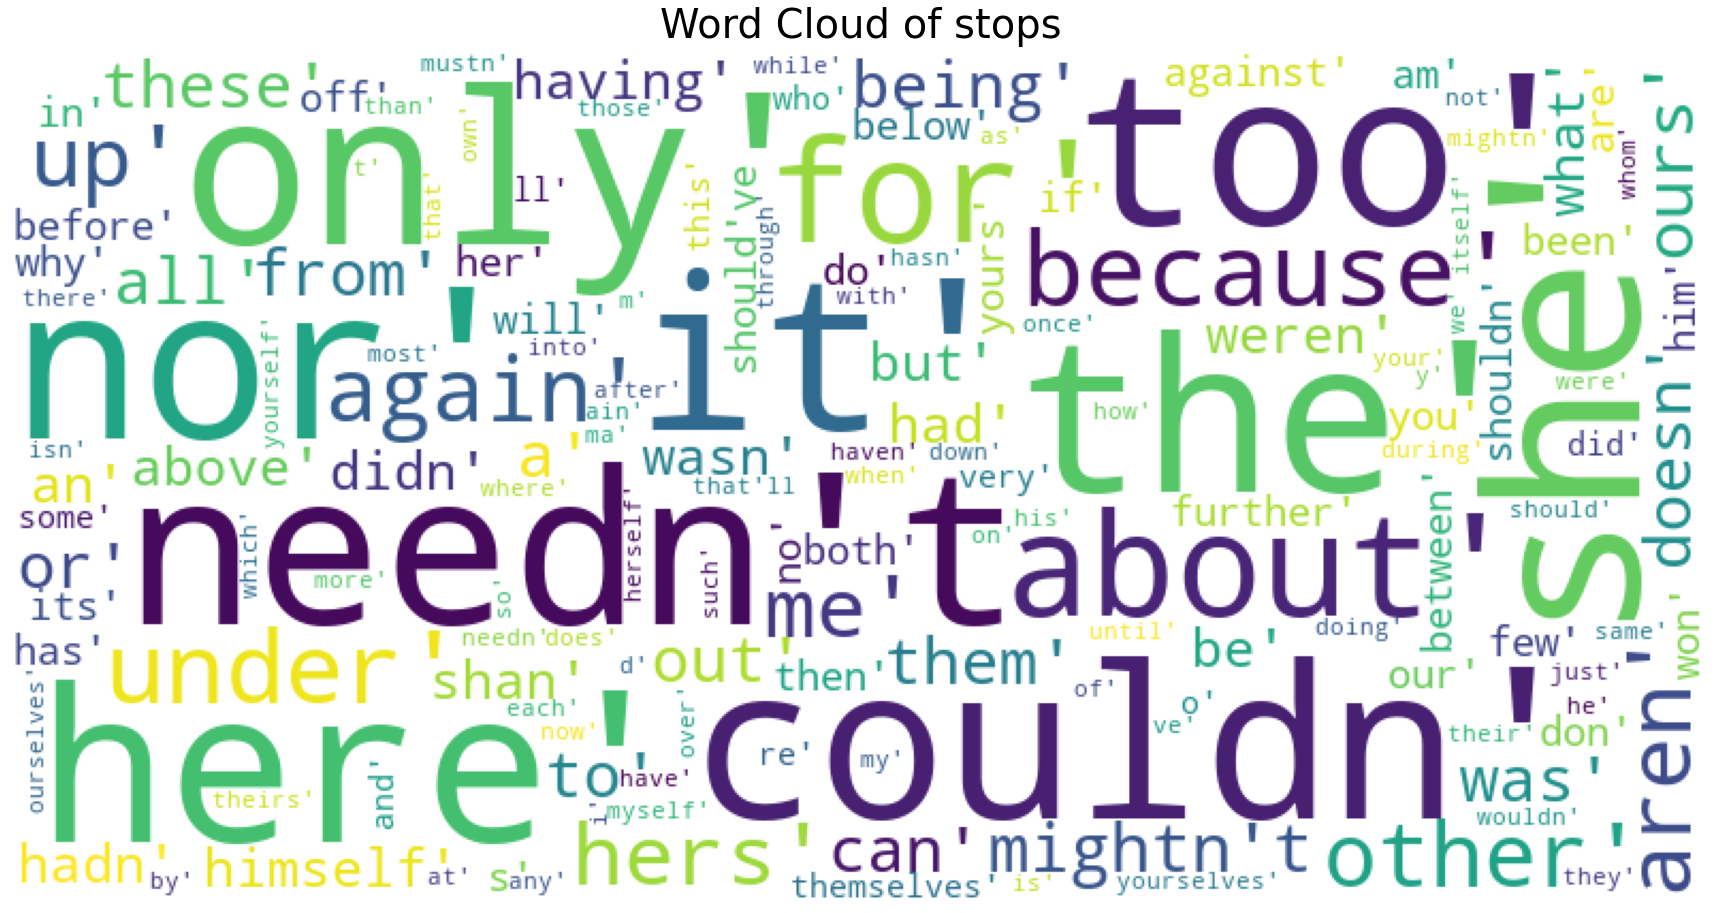

In [27]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(stops, title="Word Cloud of stops")
plt.show()

Observation: Many words here like not, aren't, are important in sentiment analysis, so will remove from stop words

In [28]:
not_stop = ["hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","aren't","couldn't","didn't","doesn't","don't","hadn't","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

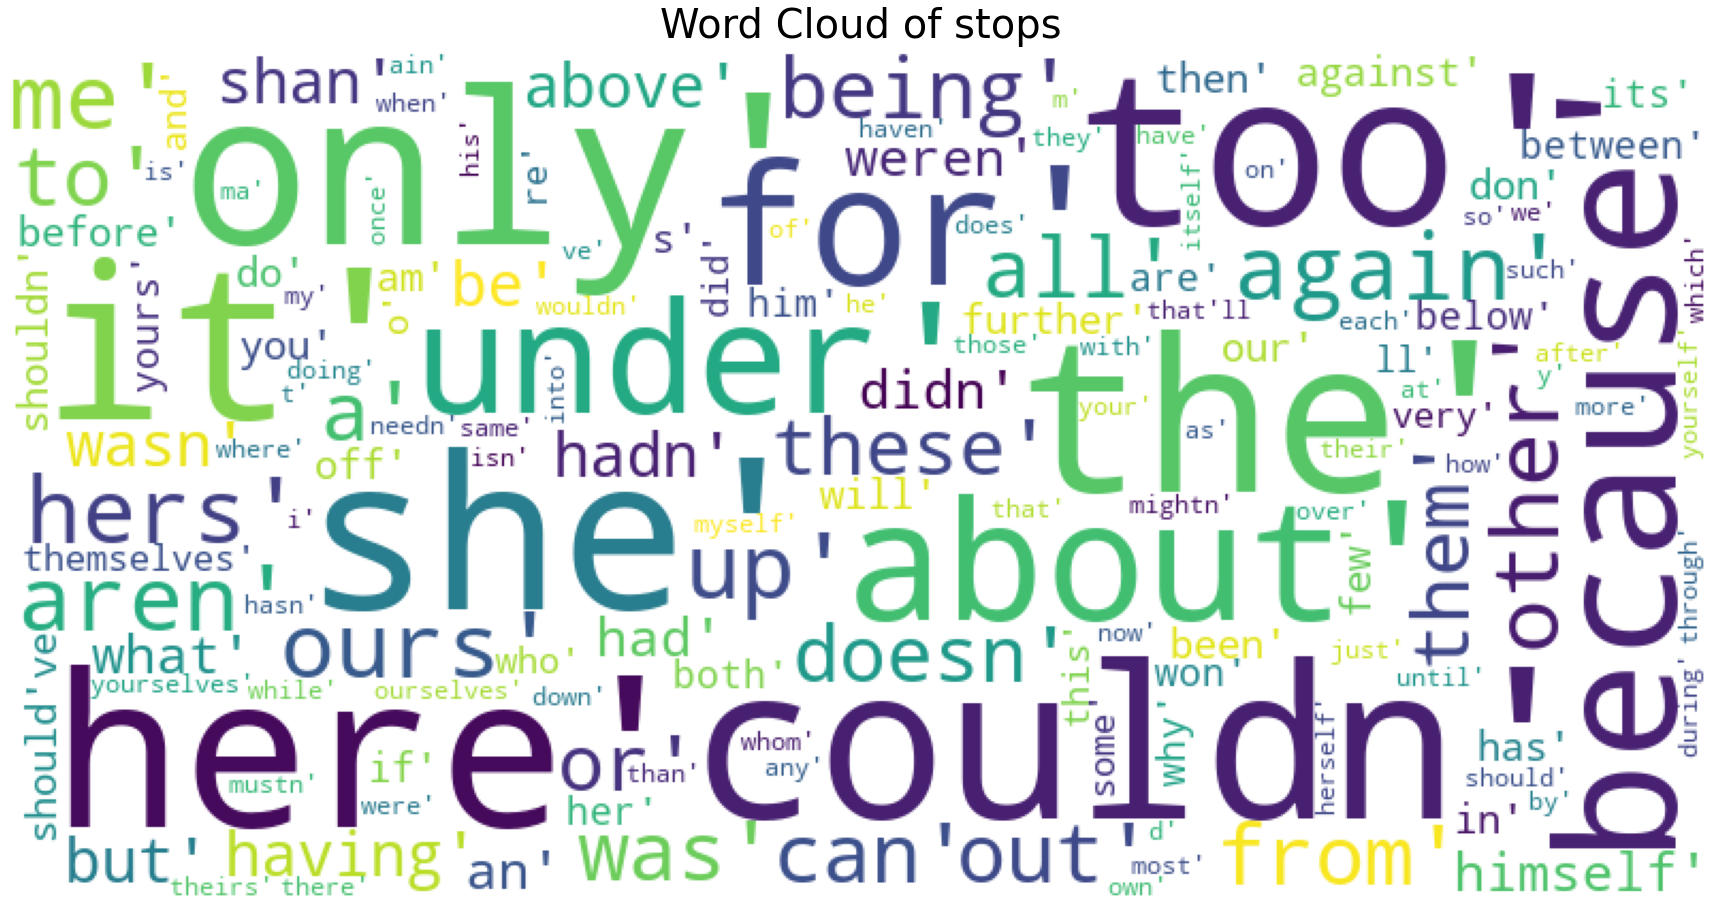

In [29]:
plot_wordcloud(stops, title="Word Cloud of stops")
plt.show()

The Reviews feature need cleaning, which is done below

In [30]:
def clean_reviews(text):
    #converting all review instances to string
    text=data['Reviews'].astype('str')
    #case text as lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    #removing  stopwords from text
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stops))
    #replacing all special characters
    text=text.str.replace('[^\w\s]','')
    # initiate nltk lemmatiser
    lemmatizer = WordNetLemmatizer()
    # lemmatise words
    text = text.apply(lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split()))
    return text

In [31]:
data['Reviews']=clean_reviews(data['Reviews'])

In [32]:
data['Reviews'][1]

'cleared right even throat hurting went away taking medicine'

**Word cloud of Reviews after text processing**

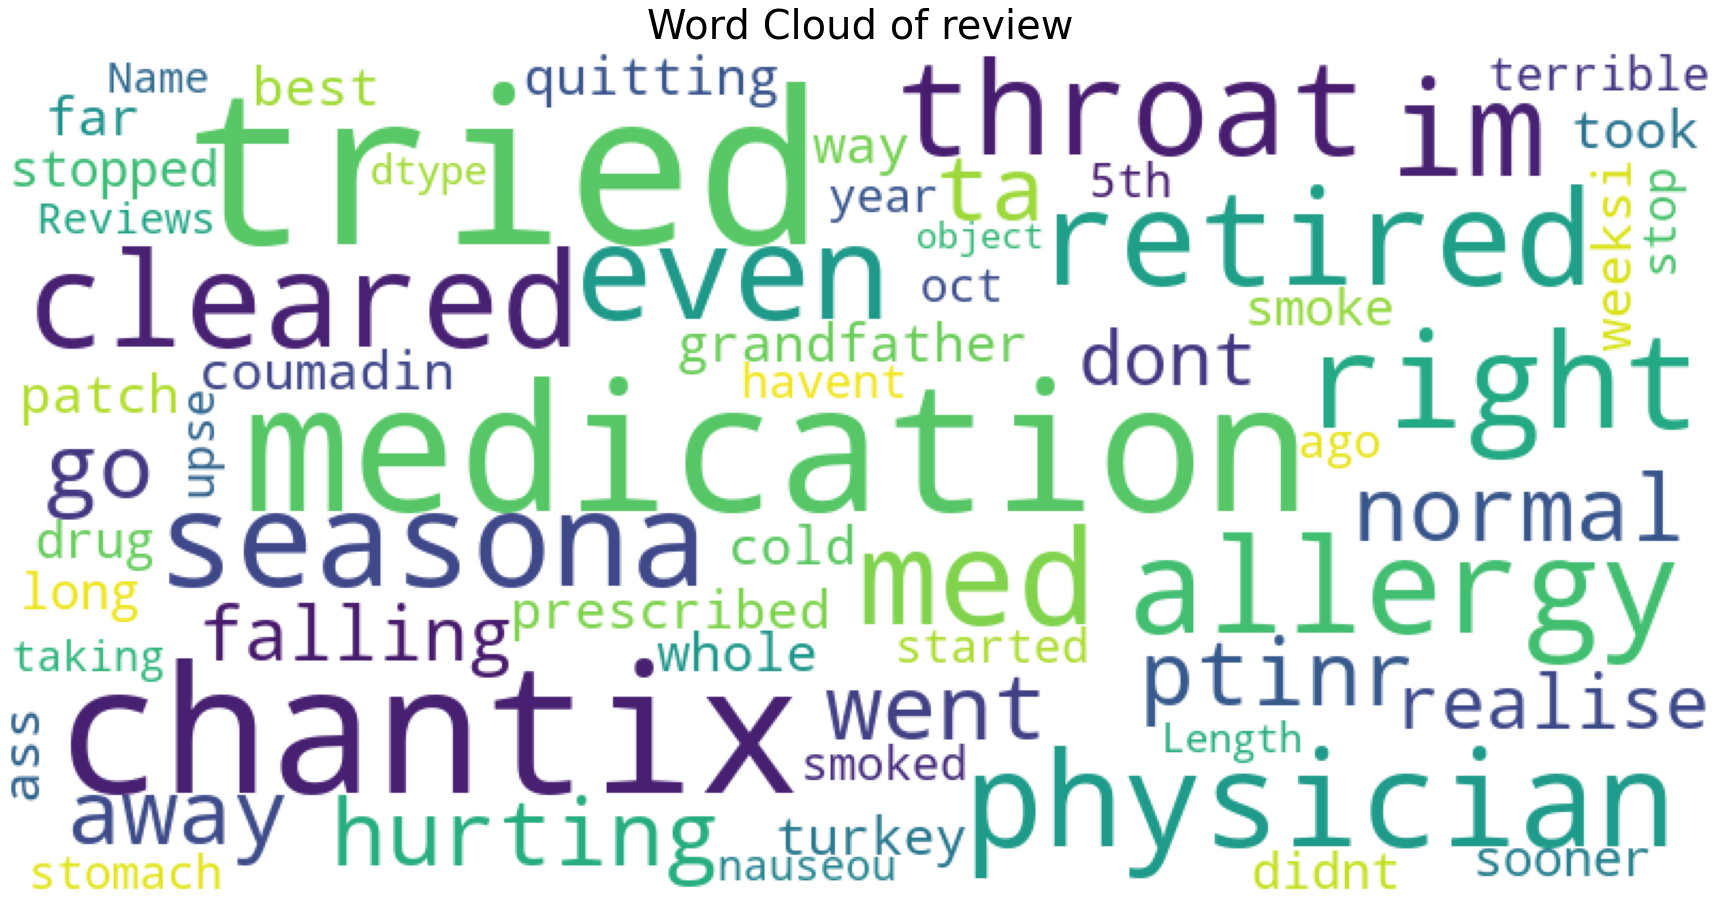

In [33]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()
    
plot_wordcloud(data["Reviews"], title="Word Cloud of review")

**Sentiment Analysis**

I have used sentiment analysis of the column 'Reviews' so I can map the sentiment score polarity to side-effect intensity like low, moderate, severe or no side-effect 

In [34]:
def sentimnt(x):
    review_sentiment=TextBlob(x).sentiment.polarity
    return review_sentiment 
 
data['sentiment_score'] = data['Reviews'].apply(sentimnt)
 


In [35]:
data.sentiment_score.value_counts()

 0.000000    50928
 0.500000     5249
 0.250000     4034
 0.100000     3578
 0.200000     3511
             ...  
 0.138480        1
-0.387603        1
 0.049383        1
-0.043718        1
 0.133889        1
Name: sentiment_score, Length: 42769, dtype: int64

#3 Data Visualization



In [36]:
data.dtypes

Condition           object
Drug                object
DrugId             float64
EaseofUse          float64
Effectiveness      float64
Reviews             object
Satisfaction       float64
Sex                 object
new_Age             object
sentiment_score    float64
dtype: object

**5.1 Numerical Features**

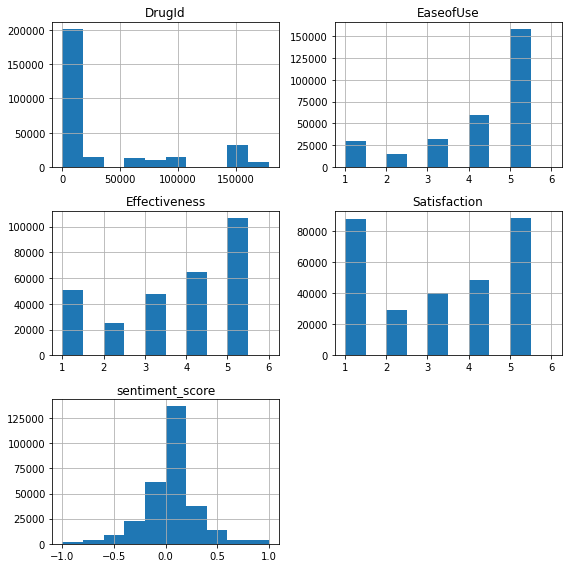

In [37]:
freqgraph=data.select_dtypes(include=['float'])
freqgraph.hist(figsize=(8,8))
plt.tight_layout()
plt.show()

Observation: The numerical column doesn't have symmetrical distribution

**5.2 Countplot of Satisfaction**

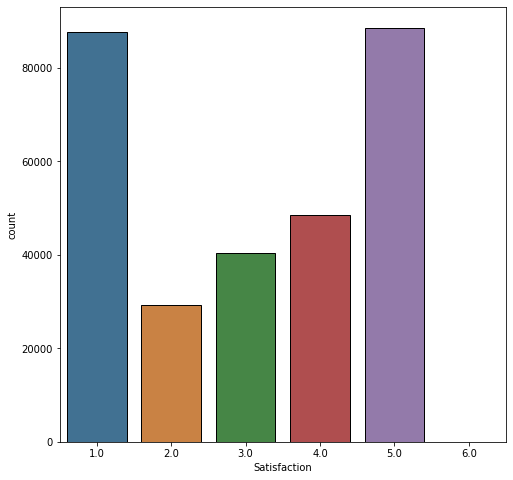

In [38]:
plt.figure(figsize = (8,8))
sns.countplot(x = data['Satisfaction'], edgecolor = 'black', saturation = 0.55)
plt.show()

Observation: The feature satisfaction is 5-star rating values. The feature is imbalanced, and it says majority recors are with rating 1 & 5

**5.3 Drug vs DrugId**

Next, I have to analyse why drug names are more in number than drugID

In [39]:
drugs = {}
for drugid, drug in data[["DrugId", "Drug"]].itertuples(index=False):
    drugs.setdefault(drugid, set()).add(drug)
drugs = {k:list(v) for k,v in drugs.items()}

drugs_with_more_names = {k:list(v) for k,v in drugs.items() if len(v) > 1}
for k,v in dict(itertools.islice(drugs_with_more_names.items(), 10)).items():
    print(f"{k:10}: {list(v)[:2]}")

  167493.0: ['lynparza', 'lynparza tablet']
   11594.0: ['lovastatin tablet, extended release 24 hr', 'lovastatin']
    7286.0: ['loteprednol etabonate drops, suspension', 'loteprednol etabonate drops, gel']
    7319.0: ['lotemax drops, gel', 'lotemax ointment']
  164437.0: ['lorcaserin tablet', 'lorcaserin tablet, extended release 24 hr']
    8892.0: ['lorazepam', 'lorazepam concentrate']
   76548.0: ['loratadine d', 'loratadine-d']
      73.0: ['loratadine tablet,disintegrating', 'loratadine']
    8555.0: ['loprox suspension, topical', 'loprox cream']
    4789.0: ['loperamide', 'loperamide liquid']


Observation: Why Drug has more values than DrugId is that some drugs are sold is different forms, like cream, pill, gel, etc. 
So I will use only DrugID for model building.

**5.4  Patient Conditions vs Drug **

Next Analysing the feature Condition to know relation between drug and condition

Text(0.5, 1.0, 'Top20 : Number of drugs per condition.')

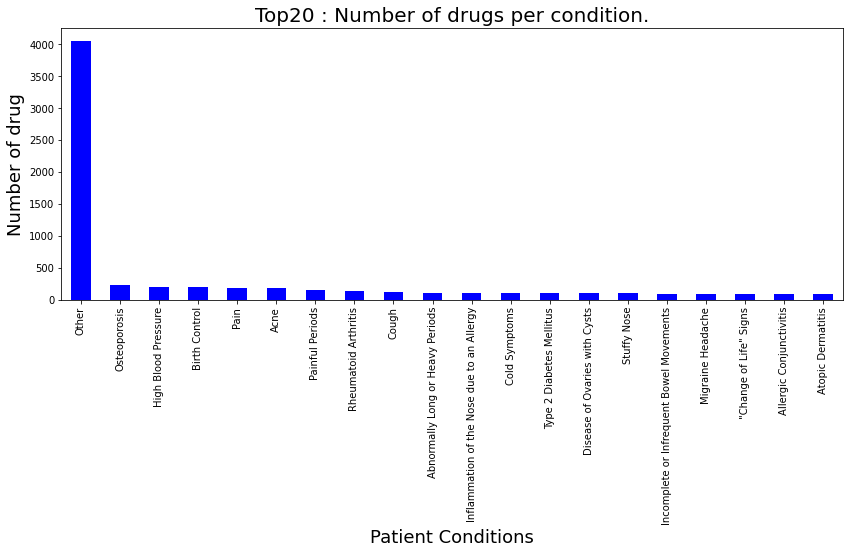

In [40]:
data1 = data.groupby(['Condition'])['Drug'].nunique().sort_values(ascending=False)
data1[0:20].plot(kind="bar", figsize = (14,5), fontsize = 10,color="blue")
plt.xlabel("Patient Conditions", fontsize = 18)
plt.ylabel("Number of drug", fontsize = 18)
plt.title("Top20 : Number of drugs per condition.", fontsize = 20)

Observation: It reveals there is uniqueness in drug provided for each condition

**N-gram Analysis of Reviews**

In [41]:
from collections import defaultdict
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]
    
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [42]:
#unigram
freq_dict = defaultdict(int)
for sent in data["Reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words-unigram"])
fig.append_trace(trace0, 1, 1)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [43]:
#Bigram
freq_dict = defaultdict(int)
for sent in data["Reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words bigram"])
fig.append_trace(trace0, 1, 1)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [44]:
#trigram
freq_dict = defaultdict(int)
for sent in data["Reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words-trigram"])
fig.append_trace(trace0, 1, 1)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [45]:
#4-gram
freq_dict = defaultdict(int)
for sent in data["Reviews"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words-4gram"])
fig.append_trace(trace0, 1, 1)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Observation: from trigram & 4 gram we get insight that mostly patients provide reviews to tell their side effects. So I got a conclusion that mapping the sentiment polarity to side-effect is effective approach toward model training

#6 Feature Engineering

In [46]:
#keeping only DrugID for model training
data=data.drop('Drug',axis=1)

Splitting the column age which is a range to two numerical age columns

In [47]:
age=data['new_Age'].str.split("-",n=1, expand=True)
age.rename(columns={0:'age_low', 1:'age_high'}, inplace=True)

In [48]:
age.head()

,age_low,age_high
0,75,None
1,25,34
2,65,74
3,75,None
4,35,44


In [49]:
data=pd.concat([age,data], axis=1)

In [50]:
data['age_high']=data['age_high'].fillna(84)

In [51]:
data.isna().sum()

age_low            0
age_high           0
Condition          0
DrugId             0
EaseofUse          0
Effectiveness      0
Reviews            0
Satisfaction       0
Sex                0
new_Age            0
sentiment_score    0
dtype: int64

In [52]:
data[["age_low", "age_high"]] = data[["age_low", "age_high"]].apply(pd.to_numeric)

In [53]:
data.dtypes

age_low              int64
age_high             int64
Condition           object
DrugId             float64
EaseofUse          float64
Effectiveness      float64
Reviews             object
Satisfaction       float64
Sex                 object
new_Age             object
sentiment_score    float64
dtype: object

I map the sentiment_score extracted from reviews to side-effect intensity

In [54]:
side_effects=[]
sides = ''
for i in data['sentiment_score']:
     if(i<0):
         sides='Severe side-effect'
     if(0<=i<0.5):
        sides='Moderate side-effect'
     if(0.5<i<1):
        sides='Less side-effect'
     if(i==1):
         sides='No side-effects'
     side_effects.append(sides)


In [55]:
data['side_effects']=side_effects

In [56]:
data.head()

,age_low,age_high,Condition,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,new_Age,sentiment_score,side_effects
0,75,84,Stuffy Nose,146724.0,5.0,5.0,im retired physician med tried allergy seasona...,5.0,Male,75,0.283333,Moderate side-effect
1,25,34,Cold Symptoms,146724.0,5.0,5.0,cleared right even throat hurting went away ta...,5.0,Female,25-34,0.285714,Moderate side-effect
2,65,74,Other,144731.0,2.0,3.0,ptinr go normal 25 100,3.0,Female,65-74,0.150000,Moderate side-effect
3,75,84,Other,144731.0,2.0,2.0,falling dont realise,1.0,Female,75,0.000000,Moderate side-effect
4,35,44,Other,144731.0,1.0,1.0,grandfather prescribed medication coumadin ass...,1.0,Male,35-44,0.046429,Moderate side-effect


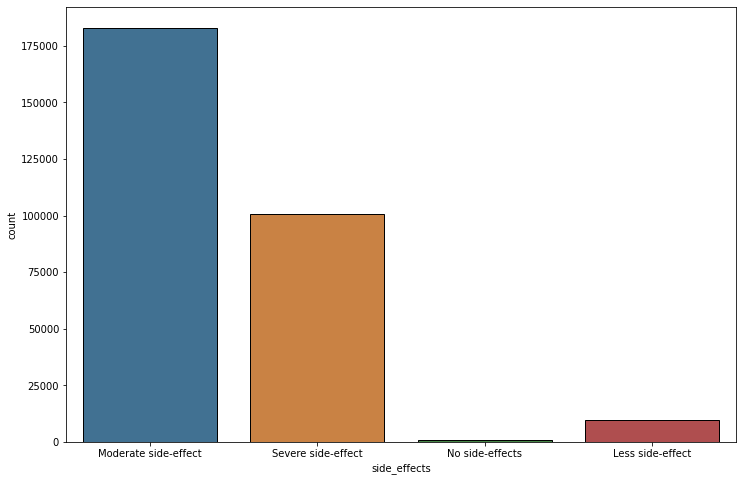

In [57]:
plt.figure(figsize = (12,8))
sns.countplot(x = data['side_effects'], edgecolor = 'black', saturation = 0.55)
plt.show()

Observation: All records in the dataset is mapped to have associated side-effects, the majority records are with moderate side-effects, followed by severe side-effects. The records with less side-effects are very less comparedc to other two.

In [58]:
data=data.drop(['sentiment_score','new_Age'],axis=1)

#7 Data Transformation

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
#vectorizer = TfidfVectorizer(ngram_range = (4, 4), stop_words=stops)
#review_vectors = vectorizer.fit_transform(data['Reviews'])

In [62]:
data_1=data

In [63]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in data[['Condition','side_effects']]:
        data[i]= le.fit_transform(data[i])

In [64]:
data=data.drop(['Reviews'],axis=1)
data=pd.get_dummies(data)
data.head()

,age_low,age_high,Condition,DrugId,EaseofUse,Effectiveness,Satisfaction,side_effects,Sex_Female,Sex_Male
0,75,84,1485,146724.0,5.0,5.0,5.0,1,0,1
1,25,34,393,146724.0,5.0,5.0,5.0,1,1,0
2,65,74,1099,144731.0,2.0,3.0,3.0,1,1,0
3,75,84,1099,144731.0,2.0,2.0,1.0,1,1,0
4,35,44,1099,144731.0,1.0,1.0,1.0,1,0,1


In [65]:
data['DrugId']=data['DrugId'].astype(int)

In [66]:
corr_matrix=data.corr()

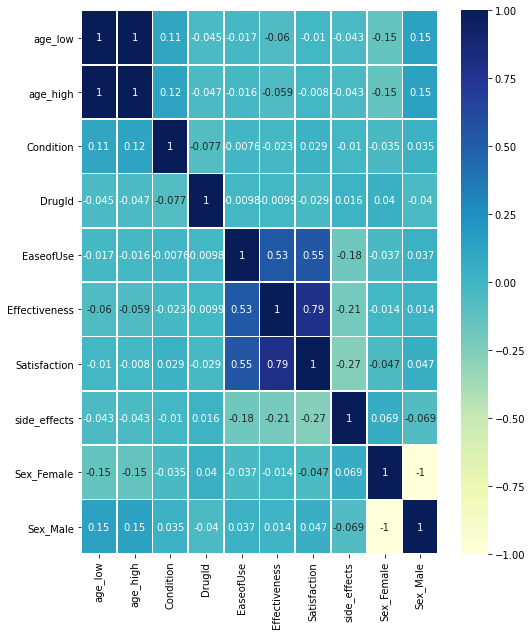

In [67]:
plt.figure(figsize=(8,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, linewidths=0.7, cmap='YlGnBu')

Observation:
Satisfaction & Effectiveness has high positive correlation

#8. **Building ML Models**

**8.1 Splitting the dataset**

In [68]:
X=data.drop(['side_effects'],axis=1)
y=data['side_effects']

In [69]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [70]:
x_train.shape

(235536, 9)

In [71]:
x_test.shape

(58885, 9)

**8.2 ML CLASSIFCATION MODELS**

**1 KNN Classification MOdel**


In [72]:
from sklearn.neighbors import KNeighborsClassifier
acc_value=[]
neighbors=np.arange(3,15)
for k in neighbors:
    classifier=KNeighborsClassifier(n_neighbors=k,metric='minkowski')
    classifier.fit(x_train,y_train)
    y_pred=classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    acc_value.append(acc)

Text(0, 0.5, 'Accuracy')

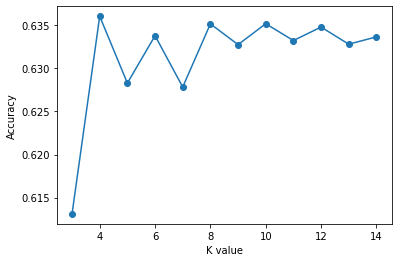

In [73]:
plt.plot(neighbors,acc_value,'o-')
plt.xlabel('K value')
plt.ylabel('Accuracy')

In [74]:
#high accuracy is for k=8
classifier=KNeighborsClassifier(n_neighbors=8,metric='minkowski')
classifier.fit(x_train,y_train)
y_pred=classifier.predict(x_test)
acc=accuracy_score(y_test,y_pred)

In [75]:
#Model Performance
print("Accuracy is:",accuracy_score(y_test,y_pred))
print("F1 score is:",f1_score(y_test,y_pred,average='weighted'))
print("Confusion Matrix")
confusion_matrix(y_test,y_pred)

Accuracy is: 0.635170247091789
F1 score is: 0.5949738420433852
Confusion Matrix


array([[  113,  1582,     0,   238],
       [  185, 31734,     2,  4874],
       [    2,   163,     1,    18],
       [  108, 14309,     2,  5554]])

**2. Decision Tree**

In [76]:
from sklearn.tree import DecisionTreeClassifier
decision_tree=DecisionTreeClassifier()

In [77]:
decision_tree.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [78]:
y_pred=decision_tree.predict(x_test)

In [79]:
#Model Performance
print("Accuracy is:",accuracy_score(y_test,y_pred))
print("F1 score is:",f1_score(y_test,y_pred,average='weighted'))
print("Confusion Matrix")
confusion_matrix(y_test,y_pred)

Accuracy is: 0.6536978857094337
F1 score is: 0.6471913094682892
Confusion Matrix


array([[  430,  1205,     4,   294],
       [  921, 28449,    82,  7343],
       [    7,   136,    24,    17],
       [  346, 10013,    24,  9590]])

**3 RANDOM FOREST CLASSIFIER**

In [80]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [81]:
random_forest.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [82]:
y_pred=random_forest.predict(x_test)
pd.DataFrame(y_pred).value_counts()

1    40772
3    17150
0      885
2       78
dtype: int64

In [83]:
#Model Performance
print("Accuracy is:",accuracy_score(y_test,y_pred))
print("F1 score is:",f1_score(y_test,y_pred,average='weighted'))
print("Confusion Matrix")
confusion_matrix(y_test,y_pred)

Accuracy is: 0.6713254648891908
F1 score is: 0.6609895997290725
Confusion Matrix


array([[  374,  1279,     2,   278],
       [  368, 29328,    43,  7056],
       [    2,   143,    26,    13],
       [  141, 10022,     7,  9803]])

**4 XGBoost Classifier**

In [84]:
from xgboost import XGBClassifier
xg=XGBClassifier()
xg.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [85]:
y_pred=xg.predict(x_test)

In [86]:
#Model Performance
print("Accuracy is:",accuracy_score(y_test,y_pred))
print("F1 score is:",f1_score(y_test,y_pred,average='weighted'))
print("Confusion Matrix")
confusion_matrix(y_test,y_pred)

Accuracy is: 0.644493504288019
F1 score is: 0.603494078595742
Confusion Matrix


array([[    0,  1849,     0,    84],
       [    0, 31886,     0,  4909],
       [    0,   181,     0,     3],
       [    0, 13908,     0,  6065]])

**5 Support Vector Classifier**

In [ ]:
from sklearn.svm import SVC

In [ ]:
#RADIAL SVM
svm_radial=SVC(kernel='linear')
svm_radial.fit(x_train,y_train)

In [ ]:
#y_pred=svm_radial.predict(x_test)

**6 Gaussian Naive Bayes**

In [87]:
from sklearn.naive_bayes import GaussianNB
classifier=GaussianNB()
classifier.fit(x_train,y_train)
y_pred=classifier.predict(x_test)

In [88]:
#Model Performance
print("Accuracy is:",accuracy_score(y_test,y_pred))
print("F score is:",f1_score(y_test,y_pred,average='weighted'))
print("COnfusion Matrix")
confusion_matrix(y_test,y_pred)

Accuracy is: 0.6364948628683026
F score is: 0.5782615844560233
COnfusion Matrix


array([[    0,  1868,     0,    65],
       [    0, 33098,     0,  3697],
       [    0,   179,     0,     5],
       [    0, 15591,     0,  4382]])

#**8.3 Hypertuning Of parameters**

**Manual Tuning of RandomForest Classifier**

In [89]:
rft=RandomForestClassifier(n_estimators=500,random_state=42,max_depth =20)

In [ ]:
rft.fit(x_train,y_train)
y_pred=rft.predict(x_test)

In [ ]:
#Model Performance
print("Accuracy is:",accuracy_score(y_test,y_pred))
print("F score is:",f1_score(y_test,y_pred,average='weighted'))
print("COnfusion Matrix")
confusion_matrix(y_test,y_pred)

Observation: After hypertuning parametes, the score has improved 

In [ ]:
pd.Series(rft.feature_importances_,index=X.columns).sort_values(ascending=False)*100

Observation: Training model based on feature importance is not apt for this specific dataset considering the project objective. But, when correlation heatmap analysed, Satisfaction and Effectiveness have high positive correlation. So will try model excluding Effectiveness

In [ ]:
#Feature Selection for RandomFOrest CLassifier
X=data.drop(['side_effects', 'Effectiveness'], axis=1)
y=data['side_effects']

In [ ]:
x_train1, x_test1, y_train1, y_test1=train_test_split(X, y, random_state=42, test_size=0.20)

In [ ]:
rft.fit(x_train1,y_train1)
y_pred=rft.predict(x_test1)

In [ ]:
#Model Performance
print("Accuracy is:",accuracy_score(y_test1,y_pred))
print("F1 score is:",f1_score(y_test1,y_pred,average='weighted'))
print("Confusion Matrix")
confusion_matrix(y_test1,y_pred)

Observation: This method caused a slight dip in scores

**RandomizedSearch Hypertuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import cross_val_score
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [15,20],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 3],
               'min_samples_split': [1, 2,3],
               'n_estimators': [100,200,500]}

clf = RandomForestClassifier()
rf = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, 
                               cv = 4, verbose= 1, random_state= 42, n_jobs = -1)
rf.fit(x_train,y_train)

In [ ]:
print(rf.best_estimator_)

In [ ]:
rfm = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42,
                       verbose=0, warm_start=False)
#rfm.fit(x_train,y_train)


In [ ]:
y_pred=rfm.predict(x_test)

In [ ]:
#Model Performance
print("Accuracy is:",accuracy_score(y_test,y_pred))
print("F score is:",f1_score(y_test,y_pred,average='weighted'))
print("COnfusion Matrix")
confusion_matrix(y_test,y_pred)

#CONCLUSION

Random Forest is the best possible model for this multi-class prediction problem. After hypertuning in manual method, it gives better accuracy of 0.683 & F1 score 0.658.  Since this is a web scrapped dataset, the  features like sex and gender, which are more releavant to project objective, has low importance in Random Forest Classifier. As future works, if more work is done on the feature 'Reviews' like bag of words or TFIDF method, the score would improve and I also would like to find out how model would work for real time dataset, in which side-effect is available differently for patients in different age-groups and gender.